# Pipeline Analytics

Extract descriptive and inferential insights into the Pipeliens in [Google-Spreadsheet](https://docs.google.com/spreadsheets/d/1uM_VpRDk2YLPrqe4KiA_20HWBWmcSw_f9orz6cuOieQ).

## TODO 

- [x] find same pipelines (methods in preprocessing) with different names and unify them
- [x] method occurences in papers, not in pipelines
- [x] improve visuals: https://networkx.org/documentation/latest/auto_examples/index.html

In [98]:
#!pip install openpyxl networkx unidecode

In [99]:
import os
os.chdir("/home/jovyan/work/BCI/SLR_EEG_motion_artifact_correction_methods/")
import sys
import time
from datetime import datetime
#  from unidecode import unidecode

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import permutation_test

In [100]:
TABLE_NAME = "Systematic Literature Review on Motion Artifact Removal of EEG Signals.xlsx"
RANDOM_SEED = 1

## Load the Spreadsheets into separate DataFrames

In [101]:
dtypes = {
     'Publication Year': pd.Int64Dtype(),
     'Create Date': pd.DatetimeIndex
}
papers_passed_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="papers_passed", dtype=dtypes, 
                                  usecols=['Reference', 'Title', 'Authors', 'Publication Year', 'Create Date'])
papers_passed_df.set_index("Reference", inplace=True)
papers_passed_df.info()
papers_passed_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, Hossain22 to Jung01
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Title             78 non-null     object        
 1   Authors           78 non-null     object        
 2   Publication Year  78 non-null     Int64         
 3   Create Date       78 non-null     datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), object(2)
memory usage: 3.1+ KB


,Title,Authors,Publication Year,Create Date
Reference,,,,
Hossain22,Motion Artifacts Correction from Single-Channel EEG and fNIRS Signals Using Novel Wavelet Packet Decomposition in Combination with Canonical Correlation Analysis,"Hossain MS, Chowdhury MEH, Reaz MBI, Ali SHM, Bakar AAA, Kiranyaz S, Khandakar A, Alhatou M, Habib R, Hossain MM.",2022,2022-05-20
Abu22,Improved Cognitive Vigilance Assessment after Artifact Reduction with Wavelet Independent Component Analysis,"Abu Farha N, Al-Shargie F, Tariq U, Al-Nashash H.",2022,2022-04-23


### Pipelines

In [102]:
dtypes = {
    'is new': pd.Int64Dtype(),
    'EEG (#ch)': pd.Int64Dtype(),
    # 'Epoch width (s)': 'float64',  # no not possible here
    'fit score (0-2)': pd.Int64Dtype(),
    'online score (0-2)': pd.Int64Dtype()
}
pipelines_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="Pipelines", header=1, 
                             na_values="-", dtype=dtypes, skipfooter=1)
pipelines_df = pipelines_df[~pipelines_df["Pipeline ID (unique per paper)"].isnull()]
pipelines_df.rename(columns={
    "Pipeline ID (unique per paper)": "Pipeline",
    "Filter (HP, LP, BP, BR)": "filter"}, inplace=True)
pipelines_df.set_index(["Reference", "Pipeline"], inplace=True)
print(pipelines_df.shape)
# TODO check if Bruhn02 is shown and needed? All fields "Pipeline ID (unique per paper)" must be provided
pipelines_df.tail(2)

(299, 59)


,,is new,EEG (#ch),"electrode type (w,g,d)",MEG,ECG,EMG,Others,filter,MA,AF,Other,Epoch width (s),Feature Extraction (#),Fourier Transf.,Wavelet Transf.,Welch,LSP,PCC,CCA,ICA,NMF,PCA,t-SNE,EMD,IVA,CSP,Other.1,Linear Regression,DA,SVM,Spatial sph. spline,GMM,Other.2,Autoencoder,GAN,Other.3,MARA,DSS,DFA,FASTER,ADJUST,HAPPE,ERASE,Other.4,DA.1,KNN,KMC,ED,NB,DT,RF,SVM.1,NN,GMM.1,MEC,Other.5,fit score (0-2),online score (0-2),details
Reference,Pipeline,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Iriarte03,HF_LF_NOTCH,0,64,NaN,NaN,NaN,NaN,NaN,1: HF (35 Hz; IIR order 4) + LF (0.3 Hz; IIR order 2) + NOTCH (50 Hz),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,NaN
Jung01,ICA,0,29,NaN,NaN,NaN,NaN,NaN,1: BP 0.1-50 Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,"It is averaged across multiple trials and even persons, therefore not applicable in this form"


### Pipeline Results

In [103]:
dtypes = {
     'Reference': 'category',
     # 'Setup ID': 'int32',  # only possible if they are non-floats
     # 'Data ID': 'int32', 
     'Metric': 'category',
     'Pipeline': 'category',
     'rank': 'float64'  # we break ties evenly
}

results_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="Results", 
                           na_values="-", header=1, dtype=dtypes, 
                           converters={"Setup ID": lambda x: str(x), "Data ID": lambda x: str(x)})
results_df.rename(columns=
                  {"rank in paper": "rank", 
                   "Pipeline ID (per paper)": "Pipeline"
                  }, inplace=True)
# results_df = results_df.loc[results_df.index.dropna()]
results_df = results_df.loc[results_df["Pipeline"].dropna().index]  # drop rows with NaN-Pipeline
results_df.drop(columns="details", inplace=True)
results_df["Setup ID"] = results_df["Setup ID"].astype(np.int32)
results_df["Data ID"] = results_df["Data ID"].astype(np.int32)
assert results_df[results_df["Metric"].isna()].shape[0] == 0  # should be empty
# results_df.dropna(inplace=True)
results_df.info()
results_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 787 entries, 0 to 811
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Reference  787 non-null    category
 1   Setup ID   787 non-null    int32   
 2   Data ID    787 non-null    int32   
 3   Metric     787 non-null    category
 4   Pipeline   787 non-null    object  
 5   rank       785 non-null    float64 
dtypes: category(2), float64(1), int32(2), object(1)
memory usage: 31.4+ KB


,Reference,Setup ID,Data ID,Metric,Pipeline,rank
0,Hossain22,1,1,SNR,WPD(db1),10.5
233,Rosanne21,2,1,accuracy,RF: ASR_ADJUST,10.0
623,Delisle-Rodriguez17,3,2,accuracy,Filter-Bank CSP,5.5
342,Leach20,1,3,Percent Agreement,original ADJUST,1.5
385,Saini20,3,3,PRD,VMD-cross,1.0


In [104]:
# Merge Pipelines with their results
results_df = results_df.merge(
    right=pipelines_df, how="outer", 
    left_on=["Reference", "Pipeline"], right_on=["Reference", "Pipeline"])
# drop missing
results_df = results_df[~results_df["rank"].isnull()]
print(results_df.shape)

(785, 65)


In [105]:
dtypes = {
     'Publication Year': pd.Int64Dtype(),
     'Create Date': pd.DatetimeIndex
}
papers_passed_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="papers_passed", dtype=dtypes, 
                                  usecols=['Reference', 'Title', 'Authors', 'Publication Year', 'Create Date'])
papers_passed_df.set_index("Reference", inplace=True)
papers_passed_df.info()
papers_passed_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, Hossain22 to Jung01
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Title             78 non-null     object        
 1   Authors           78 non-null     object        
 2   Publication Year  78 non-null     Int64         
 3   Create Date       78 non-null     datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), object(2)
memory usage: 3.1+ KB


,Title,Authors,Publication Year,Create Date
Reference,,,,
Hossain22,Motion Artifacts Correction from Single-Channel EEG and fNIRS Signals Using Novel Wavelet Packet Decomposition in Combination with Canonical Correlation Analysis,"Hossain MS, Chowdhury MEH, Reaz MBI, Ali SHM, Bakar AAA, Kiranyaz S, Khandakar A, Alhatou M, Habib R, Hossain MM.",2022,2022-05-20
Abu22,Improved Cognitive Vigilance Assessment after Artifact Reduction with Wavelet Independent Component Analysis,"Abu Farha N, Al-Shargie F, Tariq U, Al-Nashash H.",2022,2022-04-23


In [106]:
dtypes = {
     'Journal/Book': 'category',
     # 'reader': 'category',
     # 'excluded': 'int64',  # in converter (or with pd.Int64Dtype()
     'mental strategy': 'category',
     'framework': 'category',
     'open code': 'category'
}

papers_annotated_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="papers_annotated", 
                                    dtype=dtypes, converters={'excluded': lambda x: 0 if pd.isna(x) else int(x)})
papers_annotated_df = papers_annotated_df[~papers_annotated_df["reader"].isnull()]
papers_annotated_df.rename(columns={
    "sample (size, sex, age group, health status)": "sample",
    "open code (yes, no, -)": "open code"}, inplace=True)
papers_annotated_df.set_index("Reference", inplace=True)

In [107]:
# Merge with papers_passed
papers_annotated_df = papers_annotated_df.merge(papers_passed_df, how='outer')
papers_annotated_df.info()
papers_annotated_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 0 to 80
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Index                   78 non-null     float64       
 1   Title                   79 non-null     object        
 2   Authors                 79 non-null     object        
 3   Journal/Book            77 non-null     category      
 4   reader                  79 non-null     object        
 5   mental strategy         76 non-null     category      
 6   objective               77 non-null     object        
 7   data acquisition        77 non-null     object        
 8   sample                  77 non-null     object        
 9   #sample                 73 non-null     object        
 10  evaluation metrics      76 non-null     object        
 11  framework               75 non-null     category      
 12  open code               76 non-null     object      

,Index,Title,Authors,Journal/Book,reader,mental strategy,objective,data acquisition,sample,#sample,evaluation metrics,framework,open code,Innovation / Finding,further work suggested,Additional information,Publication Year,Create Date
0,8.0,Motion Artifacts Correction from Single-Channel EEG and fNIRS Signals Using Novel Wavelet Packet Decomposition in Combination with Canonical Correlation Analysis,"Hossain MS, Chowdhury MEH, Reaz MBI, Ali SHM, Bakar AAA, Kiranyaz S, Khandakar A, Alhatou M, Habib R, Hossain MM.",Sensors (Basel),mst,-,"proposes 2 methods: (i) Wavelet packet decomposition (WPD) and (ii) WPD in combination with canonical correlation analysis (WPD-CCA), for motion artifact correction from single-channel EEG and compares it to multiple existing variants in benchmark tests","Single channel EEG with ground truth reference (second EEG + accelerometer used as ground truth). 23 sets of EEG recordings, sampled at 2048 Hz, later downsampled to 256 Hz",collected from six patients\nin four different sessions,6,"SNR, average percentage reduction in artifacts",Matlab,no,"Proposed WPD algorithms were investigated by 18 different approaches / modalities where four different wavelet packet families namely Daubechies, Symlet, Coiflet, and Fejer-Korovkin wavelet packet families","The paper describes the disadvantages of many existing methods like e.g. DWT, EMD, EEMD, VMD, DWT-ICA, EMD-ICA, EEMD-ICA, EMD-CCA, EEMD-CCA, VMD-CCA,.. BUT the paper does not show direct comparision of performance of these existing methods and the proposed variants of WPD and WPD-CCA","Would benefit from largely comparing DWT, EMD, EEMD, VMD, DWT-ICA, EMD-ICA, EEMD-ICA, EMD-CCA, EEMD-CCA, VMD-CCA with proposed WPD and WPD-CCA methods",2022,2022-05-20


In [108]:
dtypes = {
    'is new': pd.Int64Dtype(),
    'EEG (#ch)': pd.Int64Dtype(),
    # 'Epoch width (s)': 'float64',
    'fit score (0-2)': pd.Int64Dtype(),
    'online score (in [0,1,2])': pd.Int64Dtype()
}
pipelines_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="Pipelines", header=1, 
                             na_values="-", dtype=dtypes)
# pipelines_df = pipelines_df[~pipelines_df["is new"].isnull()]
pipelines_df.rename(columns={
    "Pipeline ID (unique per paper)": "Pipeline",
    "Filter (HP, LP, BP, BR)": "filter"}, inplace=True)
pipelines_df.set_index(["Reference", "Pipeline"], inplace=True)
pipelines_df.head(1)

,,is new,EEG (#ch),"electrode type (w,g,d)",MEG,ECG,EMG,Others,filter,MA,AF,Other,Epoch width (s),Feature Extraction (#),Fourier Transf.,Wavelet Transf.,Welch,LSP,PCC,CCA,ICA,NMF,PCA,t-SNE,EMD,IVA,CSP,Other.1,Linear Regression,DA,SVM,Spatial sph. spline,GMM,Other.2,Autoencoder,GAN,Other.3,MARA,DSS,DFA,FASTER,ADJUST,HAPPE,ERASE,Other.4,DA.1,KNN,KMC,ED,NB,DT,RF,SVM.1,NN,GMM.1,MEC,Other.5,fit score (0-2),online score (0-2),details
Reference,Pipeline,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Hossain22,WPD(db1),1,2,NaN,NaN,NaN,NaN,acc,1: NOTCH (3rd order Butterworth; center-f at 50 Hz) + Baseline Drift Removal,NaN,NaN,NaN,NaN,NaN,NaN,2: db1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,"Online score depends on concrete implementation of WPD but should be real-time compatible by nature. The authors claim novel approach, but questionable that they invented WPD."


In [109]:
# Show all pipelines that could fit and be online
scored_pipelines = pipelines_df[["fit score (0-2)", "online score (0-2)"]].dropna()
fit_pipelines = scored_pipelines[scored_pipelines["fit score (0-2)"] * scored_pipelines["online score (0-2)"] > 0]
fit_pipelines.sample(3)

fit score (0-2)  online score (0-2)
Reference Pipeline                                              
Hossain22 WPD(db2)-CCA                     2                 2.0
Rosanne21 SVM: ADJUST                      2                 1.0
          SVM: Original EEG                2                 1.0

In [110]:
dtypes = {
     'Reference': 'category',
     'Setup ID': 'category',  # only possible if they are non-floats
     'Data ID': 'category',
     'Metric': 'category',
     'Pipeline': 'category',
     'rank': 'float64'  # we break ties evenly
}

results_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="Results", header=1, dtype=dtypes, na_values="-")
results_df.rename(columns={"rank in paper": "rank", "Pipeline ID (per paper)": "Pipeline"}, inplace=True)
# results_df = results_df.loc[results_df.index.dropna()]
results_df = results_df.loc[results_df["Pipeline"].dropna().index]  # drop rows with NaN-Pipeline
results_df.drop(columns="details", inplace=True)
# results_df.dropna(inplace=True)
results_df.info()
results_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 787 entries, 0 to 811
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Reference  787 non-null    category
 1   Setup ID   787 non-null    category
 2   Data ID    787 non-null    category
 3   Metric     787 non-null    category
 4   Pipeline   787 non-null    object  
 5   rank       785 non-null    float64 
dtypes: category(4), float64(1), object(1)
memory usage: 26.8+ KB


,Reference,Setup ID,Data ID,Metric,Pipeline,rank
17,Hossain22,1,1,SNR,WPD(fk8)-CCA,18.0
810,Iriarte03,1,1,Visual,JADE-ICA,1.0
203,Rosanne21,1,1,accuracy,RF: ADJUST,11.0


In [111]:
results_df = results_df.merge(pipelines_df, how="outer",
                              left_on=("Reference", "Pipeline"), 
                              right_on=("Reference", "Pipeline"))

## Check the validity of the ranks

In [112]:
mean_check_df = results_df.groupby(["Reference", "Setup ID", "Data ID", "Metric"]).agg(
    {"rank": ["mean", "count"]}
    ).dropna().droplevel(level=0, axis=1)
assert np.all(mean_check_df["count"] / 2.0 + 0.5 == mean_check_df["mean"])
# mean_check_df.loc[mean_check_df["count"] / 2.0 + 0.5 != mean_check_df["mean"]]
mean_check_df.head()

mean  count
Reference Setup ID Data ID Metric                                         
Abu22     1        1       Accuracy, Specificity, Sensitivity   5.5     10
Arad18    1        1       group average, SD                    1.5      2
Beach21   1        1       visual                               2.0      3
                   2       visual                               2.0      3
Benda19   1        1       peak detection efficacy              1.5      2

## Analysis

In [113]:
results_df.columns[13:51]

Index(['filter', 'MA', 'AF', 'Other', 'Epoch width (s)', 'Feature Extraction (#)', 'Fourier Transf.', 'Wavelet Transf.', 'Welch', 'LSP', 'PCC', 'CCA', 'ICA', 'NMF', 'PCA', 't-SNE', 'EMD', 'IVA', 'CSP', 'Other.1', 'Linear Regression', 'DA', 'SVM', 'Spatial sph. spline', 'GMM', 'Other.2', 'Autoencoder', 'GAN', 'Other.3', 'MARA', 'DSS', 'DFA', 'FASTER', 'ADJUST', 'HAPPE', 'ERASE', 'Other.4', 'DA.1'], dtype='object')

In [114]:
def string_concat(x):
    return ", ".join(x)


### Calculate the Average Normalize Rank over all Filters, Aggregations, Decompositions, Detection, Correction and Special algorithm

### Encoding of the Pipeline

Using a binary approach for each category

In [115]:
def encode_field(row):
    encoding = ""
    for col in ['filter', 'MA', 'AF', 'Other', 'Epoch width (s)', 'Feature Extraction (#)', 'Fourier Transf.', 'Wavelet Transf.', 'Welch', 'LSP', 'PCC', 'CCA', 'ICA', 'NMF', 'PCA', 't-SNE', 'EMD', 'IVA', 'CSP', 'Other.1', 'Linear Regression', 'DA', 'SVM', 'Spatial sph. spline', 'GMM', 'Other.2', 'Autoencoder', 'GAN', 'Other.3', 'MARA', 'DSS', 'DFA', 'FASTER', 'ADJUST', 'HAPPE', 'ERASE', 'Other.4']:
        if str(row[col]) == "nan":
            encoding += "0"
        else:
            encoding += "1"
    return encoding
    
results_df["Pipeline_encoding"] = results_df.apply(encode_field, axis=1)
results_df[["Reference", "Setup ID", "Data ID", "Metric", "Pipeline", "Pipeline_encoding", "rank"]].sample(3)

,Reference,Setup ID,Data ID,Metric,Pipeline,Pipeline_encoding,rank
450,Saavedra19,2,1,Accuracy,xDAWN,1000000000000000000000000000100000000,2.0
99,Soghoyan21,7,1,PR-AUC,LR,1000110000001000000010000000000000000,2.0
306,Saba-Sadiya21,1,2,Cohen's K,VAE,0000100000000000000000000010000000000,4.0


### Normalize rank for each "Reference", "Setup ID", "Data ID", "Metric": rank_norm

From 0-1.

In [116]:
# normalize the ranks
for idx, group in results_df.groupby(["Reference", "Setup ID", "Data ID", "Metric"]):
    max_rank = group["rank"].max()
    results_df.loc[group.index, "rank_norm"] = (group["rank"] - 1) / (max_rank - 1)
results_df[["Reference", "Setup ID", "Data ID", "Metric", "Pipeline", "Pipeline_encoding", "rank", "rank_norm"]].sample(3)

,Reference,Setup ID,Data ID,Metric,Pipeline,Pipeline_encoding,rank,rank_norm
395,Saini20,3,3,RMSE,EEMD-MCCA,0000000000001000100000000000000000000,3.5,0.500000
199,Rosanne21,1,1,accuracy,AF-RF: wICA,1010010000001000000000000000000000000,2.0,0.037037
153,Karpiel21,1,1,latency,IIR,1000000000000000000000000000000000000,3.0,1.000000


### Average rank over each Setup, Data and Metric for each "Reference" and "Pipeline"

Average rank_norm in each Reference

In [117]:
# grouping by Reference and Pipeline is okay
results_df_normed = results_df.groupby(["Reference", "Pipeline_encoding", "Pipeline"], sort=False).agg({"rank_norm": "mean"})
results_df_normed["Pipeline"] = results_df_normed.index.map(lambda x: x[-1])
results_df_normed = results_df_normed.droplevel(2)
results_df_normed.sample(3)

,,rank_norm,Pipeline
Reference,Pipeline_encoding,,
Frolich18,1000000000000000000000000000000000000,1.000000,Original EEG
Saba-Sadiya21,0000100000000000000000000001000000000,0.583333,MGAAL
Soghoyan21,1000110000001000000010000000000000000,0.440476,LR


In [118]:
value_counts_map = results_df_normed["Pipeline"].value_counts()
results_df_normed["count"] = results_df_normed["Pipeline"].apply(lambda x: value_counts_map[x])
results_df_normed = results_df_normed[~results_df_normed["rank_norm"].isnull()]  # drop nas (only one entry)
results_df_normed.sample(3)

,,rank_norm,Pipeline,count
Reference,Pipeline_encoding,,,
Gwin10,1000100000001000000010000000000000000,0.0,IC-based artifact removal,1
Val-Calvo19,1001110100001000000000000000000000000,1.0,Linear dynamic system,1
Grosselin19,1000101000000000000101000000000000000,1.0,LDA,1


### Average normalized pipeline rank over each pipeline encoding per reference

In [119]:
# grouping by Reference and Pipeline encoding
results_df_normed2 = results_df_normed.groupby(["Reference", "Pipeline_encoding"], sort=False).agg({"rank_norm": ["count", "mean"], "Pipeline": string_concat})
# results_df_normed["Pipeline"] = results_df_normed.index.map(lambda x: x[-1])
results_df_normed2.columns = ["rank_norm_count", "rank_norm_mean", "Pipelines"]
results_df_normed2.sample(3)

,,rank_norm_count,rank_norm_mean,Pipelines
Reference,Pipeline_encoding,,,
Mucarquer20,1000100000000000000000000000100000000,1,1.000,SuBAR
DelPozo-Banos17,1000000100001000000000000000000000000,1,0.500,ICAW-WithoutLCF
Jas17,1000000000000000000000000100000000000,2,0.375,"Autoreject, RANSAC"


### Average normalized pipeline rank over all references

In [120]:
results_df_normed3 = results_df_normed2.groupby(["Pipeline_encoding"], sort=False).agg({"rank_norm_count": ["sum", "count"], "rank_norm_mean": "mean", "Pipelines": string_concat})
results_df_normed3.columns = ["pipeline_count", "reference_count", "mean_normalized_rank", "Pipelines"]
results_df_normed3.sort_values(by=["reference_count", "mean_normalized_rank"], ascending=(False, True), inplace=True)
print(results_df_normed3.shape)
results_df_normed3.head(15)

(127, 4)


,pipeline_count,reference_count,mean_normalized_rank,Pipelines
Pipeline_encoding,,,,
1000000000000000000000000000000000000,17,13,0.956044,"FIR, IIR, FFT, NOTCH, Original EEG, Original EEG, Original EEG, Original EEG, Gel, Original EEG, Dry, Original EEG, NoReject, Original EEG, Original EEG, Original EEG, LP-FILTERING, Original EEG, HF_LF_NOTCH"
1000000000000000000100000000000000000,5,4,0.515625,"SSD, SNS, STAR, STAR+JD, SOBI"
1000000000001000000000000000000000000,16,4,0.633333,"FastICA-SVM, FastICA-KNN, FastICA-DT, FastICA-DA, FastICA-NB, wICA-SVM, wICA-KNN, wICA-DT, wICA-DA, wICA-NB, None-WithoutLCF, IMICA, Infomax, FastICA, JADE, SCICA"
1000110000001000000000000000000000000,4,3,0.416667,"ASR-AMICA, ASR-merged-AMICA, CR1, AMICA"
0000000000000000000000000000000000000,4,3,0.593750,"Standard Pipeline, MADE, Original EEG, JD"
1000000000001000000000000000100001000,2,2,0.244048,"ADJUST, ADJUST-WithLCF"
1000000000010000100000000000000000000,3,2,0.316667,"EEMD-CCA, sEEMD-CCA, EEMD-CCA"
1000010000001010000000000000000000000,5,2,0.601852,"RF: ASR_wICA, SVM: ASR_wICA, LPM-Setup1, SVM-Setup1, LDA-Setup1"
1000101000000000000000000000000000000,4,2,0.833333,"FFT-DBN, FFT-SVM, Robust Method w/Bayes, Standard Method w/Jackknife"


### Calculate the Average Normalize Rank over all Decompositions methods

### Encoding of the Pipeline

Using a binary approach for each category

In [121]:
def encode_field(row):
    encoding = ""
    for col in ['Fourier Transf.', 'Wavelet Transf.', 'Welch', 'LSP', 'PCC', 'CCA', 'ICA', 'NMF', 'PCA', 't-SNE', 'EMD', 'IVA', 'CSP', 'Other.1',]:
        if str(row[col]) == "nan":
            encoding += "0"
        else:
            encoding += "1"
    return encoding
    
results_df["Pipeline_encoding"] = results_df.apply(encode_field, axis=1)
results_df[["Reference", "Setup ID", "Data ID", "Metric", "Pipeline", "Pipeline_encoding", "rank"]].sample(3)

,Reference,Setup ID,Data ID,Metric,Pipeline,Pipeline_encoding,rank
112,Soghoyan21,6,1,ROC-AUC,XGB,00000010000000,2.0
646,DelPozo-Banos17,1,1,FAR,FASTER-WithoutLCF,00000010000000,5.5
759,Yong12,3,1,TPR,ASWTD-Hard,11000000000000,6.0


### Normalize rank for each "Reference", "Setup ID", "Data ID", "Metric": rank_norm

From 0-1.

In [122]:
# normalize the ranks
for idx, group in results_df.groupby(["Reference", "Setup ID", "Data ID", "Metric"]):
    max_rank = group["rank"].max()
    results_df.loc[group.index, "rank_norm"] = (group["rank"] - 1) / (max_rank - 1)
results_df[["Reference", "Setup ID", "Data ID", "Metric", "Pipeline", "Pipeline_encoding", "rank", "rank_norm"]].sample(3)

,Reference,Setup ID,Data ID,Metric,Pipeline,Pipeline_encoding,rank,rank_norm
330,Li21,1,1,z-scored power,ERASE-Real-EMG,00000000000000,1.5,0.166667
238,Rosanne21,2,1,accuracy,SVM: ASR_ADJUST,00000000100000,20.0,0.703704
662,Roy17,1,1,Correlation,EEMD-GECCA-SWT,01000100001000,2.0,0.333333


### Average rank over each Setup, Data and Metric for each "Reference" and "Pipeline"

Average rank_norm in each Reference

In [123]:
# grouping by Reference and Pipeline is okay
results_df_normed = results_df.groupby(["Reference", "Pipeline_encoding", "Pipeline"], sort=False).agg({"rank_norm": "mean"})
results_df_normed["Pipeline"] = results_df_normed.index.map(lambda x: x[-1])
results_df_normed = results_df_normed.droplevel(2)
results_df_normed.sample(3)

,,rank_norm,Pipeline
Reference,Pipeline_encoding,,
Rosanne21,00000000100000,0.685185,AF-SVM: ASR_ADJUST
Kaur21,00000000001000,1.000000,EMD
Saba-Sadiya21,00000000000000,0.236111,AUTO


In [124]:
value_counts_map = results_df_normed["Pipeline"].value_counts()
results_df_normed["count"] = results_df_normed["Pipeline"].apply(lambda x: value_counts_map[x])
results_df_normed = results_df_normed[~results_df_normed["rank_norm"].isnull()]  # drop nas (only one entry)
results_df_normed.sample(5)

rank_norm                 Pipeline  count
Reference   Pipeline_encoding                                           
Mucarquer20 00000100001000      1.000000                 EEMD-CCA      5
Tost21      00000000000000      1.000000  energy double-rejection      1
Roy17       01000100001000      0.833333             EEMD-CCA-SWT      1
Rosanne21   00000010000000      0.962963                SVM: wICA      1
            00000010100000      0.185185             RF: ASR_wICA      1

### Average normalized pipeline rank over each pipeline encoding per reference

In [125]:
# grouping by Reference and Pipeline encoding
results_df_normed2 = results_df_normed.groupby(["Reference", "Pipeline_encoding"], sort=False).agg({"rank_norm": ["count", "mean"], "Pipeline": string_concat})
# results_df_normed["Pipeline"] = results_df_normed.index.map(lambda x: x[-1])
results_df_normed2.columns = ["rank_norm_count", "rank_norm_mean", "Pipelines"]
results_df_normed2.sample(5)

,,rank_norm_count,rank_norm_mean,Pipelines
Reference,Pipeline_encoding,,,
DelPozo-Banos17,01000010000000,2,0.392857,"ICAW-WithLCF, ICAW-WithoutLCF"
Iriarte03,00000000000000,1,1.000000,HF_LF_NOTCH
Kumaravel22,00000000000000,1,0.583333,CRD
Leach20,10000010000000,3,0.418519,"adjusted ADJUST, original ADJUST, ICLabel"
Delisle-Rodriguez17,00000000000010,1,1.000000,CSP


### Average normalized pipeline rank over all references

In [126]:
results_df_normed3 = results_df_normed2.groupby(["Pipeline_encoding"], sort=False).agg({"rank_norm_count": ["sum", "count"], "rank_norm_mean": "mean", "Pipelines": string_concat})
results_df_normed3.columns = ["pipeline_count", "reference_count", "mean_normalized_rank", "Pipelines"]
results_df_normed3.sort_values(by=["reference_count", "mean_normalized_rank"], ascending=(False, True), inplace=True)
print(results_df_normed3.shape)
results_df_normed3.head(15)

(32, 4)


,pipeline_count,reference_count,mean_normalized_rank,Pipelines
Pipeline_encoding,,,,
00000000000000,60,24,0.798300,"Standard Pipeline, MADE, CRD, Original EEG, FIR, IIR, FFT, NOTCH, Original EEG, AF acc, AF gyro, distribution-based double-rejection, energy double-rejection, hybrid double-rejection, AF-RF: Original EEG, AF-RF: ADJUST, AF-RF: HAPPE, AF-SVM: Original EEG, AF-SVM: ADJUST, AF-SVM: HAPPE, RF: Original EEG, RF: ADJUST, RF: HAPPE, SVM: Original EEG, SVM: ADJUST, SVM: HAPPE, OCSVN, AUTO, VAE, GAAL, MGAAL, Original EEG, Original EEG, ERASE-Real-EMG, ERASE-Simulated-EMG, SuBAR, xDAWN, METS_SEWS_1, METS_SEWS_2, Original EEG, Original EEG, FASTER, FASTER-MARA, Gel, Original EEG, Dry, Original EEG, Autoreject, FASTER, RANSAC, NoReject, Original EEG, JD, Original EEG, Original EEG, Raw, Original EEG, LP-FILTERING, DETECT, Original EEG, channel-based artifact removal, HF_LF_NOTCH"
00000010000000,60,18,0.445411,"FastICA-SVM, FastICA-KNN, FastICA-DT, FastICA-DA, FastICA-NB, wICA-SVM, wICA-KNN, wICA-DT, wICA-DA, wICA-NB, MADE, HAPPE, LR, XGB, SVM, AF-RF: wICA, AF-SVM: wICA, RF: wICA, SVM: wICA, Conventional-ICA, Single-Layer-AMICA, Dual-Layer-AMICA, Noise-Cancel-AMICA, ASR-AMICA, ASR-merged-AMICA, UAR, MARA, SASICA, TDSEP, Infomax, FastICA, HP-TDSEP, HP-Infomax, HP-FastICA, Fourier-ICA, HAPPE, ICA-MARA, ADJUST, SASICA, CR1, None-WithLCF, ADJUST-WithLCF, FASTER-WithLCF, None-WithoutLCF, ADJUST-WithoutLCF, FASTER-WithoutLCF, Our Method, FASTER, ADJUST, Auto-mutual information, K-means with similarity, IMICA, Infomax, FastICA, JADE, AMICA, WICA, SCICA, IC-based artifact removal, JADE-ICA"
00000000000001,14,7,0.424486,"HBOS, LOF, ABOD, LSCP (2*HBOS+OCSVM), VMD-cross, SSD, Filter WAR, LAR, WAR, Riemann Kernel, SNS, STAR, STAR+JD, SOBI"
00000000100000,17,7,0.750827,"APICE, APICEa, APICE+DSS, AF-RF: ASR, AF-RF: ASR_ADJUST, AF-SVM: ASR, AF-SVM: ASR_ADJUST, RF: ASR, RF: ASR_ADJUST, SVM: ASR, SVM: ASR_ADJUST, PCA, ASR, rASR, ASR, PCA, ASR"
00000010100000,15,5,0.457672,"APICE+wICA+iMARA, AF-RF: ASR_wICA, AF-SVM: ASR_wICA, RF: ASR_wICA, SVM: ASR_wICA, ASR, Gel, 20 IC, Gel, 50 IC, Gel, 80 IC, Dry, 20 IC, Dry, 50 IC, Dry, 80 IC, LPM-Setup1, SVM-Setup1, LDA-Setup1"
10000000000000,9,5,0.850000,"No correction, MC-Wiener-Filtered, MC-Wiener-Unfiltered, FFT-DBN, FFT-SVM, Robust Method w/Bayes, Standard Method w/Jackknife, Ignore, Reject"
00000100001000,8,4,0.383780,"EEMD-CCA, sEEMD-CCA, EEMD-CCA, EEMD-CCA-2EMG, EEMD-CCA-4EMG, EEMD-CCA-8EMG, EEMD-CCA, EEMD-CCA"
01000010000000,9,3,0.630952,"EAWICA-ALL, ICA-W-ALL, EAWICA-DELTA, ICA-W-DELTA, Linear dynamic system, Savetzky-Golay, wICA, ICAW-WithLCF, ICAW-WithoutLCF"
10000010000000,5,3,0.736087,"adjusted ADJUST, original ADJUST, ICLabel, AMICA, ERICA"


### Mean normalized rank per method

In [127]:
N_PAPER_THRESHOLD = 5
from IPython.display import display, Markdown

# count the occurences of types in all pipelines
# TODO could be done for different fitnesses and online scores
# TODO MultiIndex with algorithm type and method
print(f'Number of occurences of each algorithm in {len(results_df.groupby("Reference").agg("count"))} papers and {len(results_df.groupby(["Reference", "Pipeline"]).agg("count"))} pipelines with mean ranks:\n')


keys = [key for key in results_df.columns[13:-17] if not key.startswith("Other")]
df_keys = pd.DataFrame(columns=["#papers", "#pipelines", "mean normalized rank"], index=keys)
for key in keys:
    df_ = results_df[~results_df[key].isnull()]
    means = df_.groupby("Reference").agg({"rank_norm": "mean"})
    df_keys.loc[key, "#papers"] = len(means)
    df_keys.loc[key, "#pipelines"] = df_.groupby("Reference").agg({"rank_norm": "count"}).sum()[0]
    df_keys.loc[key, "mean normalized rank"] = means.mean()[0]

Number of occurences of each algorithm in 78 papers and 303 pipelines with mean ranks:



In [128]:
def my_permutation_test(x, y, runs=1000):
    dist_orig = (x.mean() - y.mean())
    counter = 0
    for _ in range(runs):
        perm = np.random.permutation(np.concatenate([x, y]))
        x_mean = np.mean(perm[:len(x)])
        y_mean = np.mean(perm[len(x):])
        counter += dist_orig >= (x_mean - y_mean)
    p_value = counter / runs
    return p_value

my_permutation_test(np.random.normal(0, 1, 100), np.random.normal(0.5, 1, 100), runs=1000)

0.042

In [129]:
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

permutation_test((np.random.normal(0, 1, 100), np.random.normal(0.5, 1, 100)), 
                 statistic, permutation_type="independent", n_resamples=10_000, alternative="two-sided", random_state=RANDOM_SEED).pvalue

0.00019998000199980003

In [130]:
N_PAPER_THRESHOLD = 2
N_PIPELINE_THRESHOLD = 10
SIGNIFICANCE_LEVELS = (0.05, 0.01, 0.001)
from IPython.display import display, Markdown

# count the occurences of types in all pipelines
# TODO could be done for different fitnesses and online scores
# TODO MultiIndex with algorithm type and method
print(f'Number of occurences of each algorithm in {len(results_df.groupby("Reference").agg("count"))} papers and {len(results_df.groupby(["Reference", "Pipeline"]).agg("count"))} pipelines with mean ranks:\n')


keys = [key for key in results_df.columns[13:-17] if not key.startswith("Other")]

df_keys = pd.DataFrame(columns=pd.MultiIndex.from_tuples(list(zip(*[
    ["with/without Method", "with/without Method", "with/without Method", "diff.", "p-value"],
    ["#papers", "#pipelines", "mean norm. rank", "", ""]]))), index=keys)

for key in keys:
    # Results with and without the method
    df_with = results_df[~results_df[key].isnull()]
    means_with = df_with.groupby("Reference").agg({"rank_norm": "mean"}).dropna()
    df_wo = results_df[results_df[key].isnull()]
    means_wo = df_wo.groupby("Reference").agg({"rank_norm": "mean"}).dropna()
    
    df_keys.loc[key, ("with/without Method", "#papers")] = f"{len(means_with)} / {len(means_wo)}"
    df_keys.loc[key, ("with/without Method", "#pipelines")] = f'{df_with.groupby("Reference").agg({"rank_norm": "count"}).sum()[0]} / {df_wo.groupby("Reference").agg({"rank_norm": "count"}).sum()[0]}'
    df_keys.loc[key, ("with/without Method", "mean norm. rank")] = f'{means_with.mean()[0]:.3f}/{means_wo.mean()[0]:.3f}'
    df_keys.loc[key, ("diff.")] = np.round(means_with.mean()[0] - means_wo.mean()[0], 4)

    # Permutation test
    if len(means_with) > 1 and len(means_wo) > 1:
        p_value = permutation_test((means_with["rank_norm"].to_numpy(), means_wo["rank_norm"].to_numpy()), 
                                   statistic, permutation_type="independent", n_resamples=10_000, alternative="two-sided", random_state=RANDOM_SEED).pvalue        
        # if p_value < SIGNIFICANCE_LEVELS[2]:
        #     df_keys.loc[key, ("p-value")] = f"***{p_value:.4f}"
        # elif p_value < SIGNIFICANCE_LEVELS[1]:
        #     df_keys.loc[key, ("p-value")] = f"**{p_value:.4f}"
        # elif p_value < SIGNIFICANCE_LEVELS[0]:
        #     df_keys.loc[key, ("p-value")] = f"*{p_value:.4f}"
        # else:
        #     df_keys.loc[key, ("p-value")] = f"{p_value:.4f}"
        df_keys.loc[key, ("p-value")] = f"{p_value:.4f}"
    else:
        df_keys.loc[key, ("p-value")] = np.nan

df_keys_sorted = df_keys[np.logical_and(df_keys[("with/without Method", "#papers")].apply(lambda x: int(x.split(" / ")[0])) >= N_PAPER_THRESHOLD,
                                        df_keys[("with/without Method", "#pipelines")].apply(lambda x: int(x.split(" / ")[0])) >= N_PIPELINE_THRESHOLD)
                        ].sort_values(by=("diff."), ascending=True)
print("For each method in a pipeline, the numbers of papers and pipelines using and not using it are depicted with their respective mean normalized rank.", 
      "Additionally, a permutation test with 10,000 runs is applied that shows the p-value for using the respective method in a pipeline.")
df_keys_sorted

Number of occurences of each algorithm in 78 papers and 303 pipelines with mean ranks:

For each method in a pipeline, the numbers of papers and pipelines using and not using it are depicted with their respective mean normalized rank. Additionally, a permutation test with 10,000 runs is applied that shows the p-value for using the respective method in a pipeline.


with/without Method                              diff. p-value
                                   #papers #pipelines mean norm. rank                
Linear Regression                   3 / 51   45 / 737     0.252/0.613 -0.3606  0.0018
AF                                  3 / 51   65 / 717     0.331/0.604 -0.2733  0.0002
ADJUST                              7 / 51   50 / 732     0.407/0.599 -0.1915  0.0012
CCA                                 9 / 49   55 / 727     0.459/0.625 -0.1656  0.0042
ICA                                28 / 41  283 / 499     0.511/0.673 -0.1624  0.0122
SVM                                 3 / 51   63 / 719     0.471/0.605 -0.1338  0.0458
Epoch width (s)                    26 / 33  454 / 328     0.524/0.658 -0.1333  0.0154
EMD                                 7 / 49   70 / 712     0.497/0.619  -0.122  0.0414
CSP                                 3 / 50   20 / 762     0.492/0.600 -0.1081  0.1316
Feature Extraction (#)             17 / 39  393 / 389     0.513/0.616 -0.1024  0.0960
Spatial sph. spline                 3 / 50   56 / 726     0.524/0.602 -0.0779  0.4638
FASTER                              6 / 50   45 / 737     0.527/0.597 -0.0707  0.2658
MARA                                4 / 51   12 / 770     0.552/0.597 -0.0446  0.7191
Wavelet Transf.                     8 / 48  114 / 668     0.577/0.608 -0.0309  0.6863
PCA                                12 / 50   91 / 691     0.660/0.612  0.0484  0.4500
PCC                                 2 / 51   22 / 760     0.687/0.598  0.0892  0.4761
Fourier Transf.                     8 / 44  111 / 671     0.697/0.584  0.1128  0.0924
MA                                  2 / 50   51 / 731     0.753/0.598   0.155  0.2066
filter                             46 / 10  582 / 200     0.629/0.454  0.1749  0.0068
DA                                  3 / 49   52 / 730     0.836/0.588   0.248  0.0314

In [131]:
print(
    df_keys_sorted.rename(index={"Feature Extraction (#)": "Feature Extr."}
                         ).to_latex())

\begin{tabular}{llllll}
\toprule
{} & \multicolumn{3}{l}{with/without Method} &   diff. & p-value \\
{} &             \#papers & \#pipelines & \multicolumn{3}{l}{mean norm. rank} \\
\midrule
Linear Regression   &              3 / 51 &   45 / 737 &     0.252/0.613 & -0.3606 &  0.0018 \\
AF                  &              3 / 51 &   65 / 717 &     0.331/0.604 & -0.2733 &  0.0002 \\
ADJUST              &              7 / 51 &   50 / 732 &     0.407/0.599 & -0.1915 &  0.0012 \\
CCA                 &              9 / 49 &   55 / 727 &     0.459/0.625 & -0.1656 &  0.0042 \\
ICA                 &             28 / 41 &  283 / 499 &     0.511/0.673 & -0.1624 &  0.0122 \\
SVM                 &              3 / 51 &   63 / 719 &     0.471/0.605 & -0.1338 &  0.0458 \\
Epoch width (s)     &             26 / 33 &  454 / 328 &     0.524/0.658 & -0.1333 &  0.0154 \\
EMD                 &              7 / 49 &   70 / 712 &     0.497/0.619 &  -0.122 &  0.0414 \\
CSP                 &              3 / 50

/tmp/ipykernel_247506/1391621042.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ).to_latex())


In [132]:
# df_keys_sorted = df_keys[df_keys["#papers"] >= N_PAPER_THRESHOLD].sort_values(by="mean normalized rank", ascending=True)


# table  = "Method | #papers | #pipelines | mean norm. rank \n"
# table += " --- | --- | --- | --- \n"
# for key, row in df_keys_sorted.iterrows():
#     table += f'{key} | {row["#papers"]} | {row["#pipelines"]} | {row["mean normalized rank"]:.4f} \n'
# print("Mean normalized score for all usages of selected methods, averaged accross each reference.")
# Markdown(table)

## Newly proposed pipelines against existing

In [133]:
results_df[results_df["is new"]==1]["rank_norm"].mean()

0.4088248636609293

In [134]:
results_df[results_df["is new"]==0]["rank_norm"].mean()

0.6323988601586008

In [135]:
results_df[results_df["is new"]==0]["rank_norm"].mean() - results_df[results_df["is new"]==1]["rank_norm"].mean()

0.2235739964976715

### Network construction

In [136]:
import networkx as nx

In [137]:
graph = nx.DiGraph()
for idx, group in results_df.groupby(["Reference", "Setup ID", "Data ID", "Metric"]):
    if len(group) > 3:
        # print(group)
        for idx_i, row_i in group.iterrows():
            for idx_j, row_j in group.iterrows():
                if idx_i > idx_j:
                    if row_i["rank"] <= row_j["rank"]:
                        graph.add_edge(row_i["Pipeline"], row_j["Pipeline"])
                    if row_j["rank"] <= row_i["rank"]:
                        graph.add_edge(row_j["Pipeline"], row_i["Pipeline"])
        break

In [138]:
graph.edges()

OutEdgeView([('FastICA-SVM', 'FastICA-KNN'), ('FastICA-SVM', 'FastICA-DT'), ('FastICA-SVM', 'FastICA-NB'), ('FastICA-SVM', 'wICA-SVM'), ('FastICA-SVM', 'wICA-KNN'), ('FastICA-SVM', 'wICA-DT'), ('FastICA-SVM', 'wICA-NB'), ('FastICA-KNN', 'FastICA-DT'), ('FastICA-KNN', 'FastICA-NB'), ('FastICA-KNN', 'wICA-KNN'), ('FastICA-KNN', 'wICA-DT'), ('FastICA-KNN', 'wICA-NB'), ('FastICA-DT', 'FastICA-NB'), ('FastICA-DT', 'wICA-DT'), ('FastICA-DT', 'wICA-NB'), ('FastICA-DA', 'FastICA-SVM'), ('FastICA-DA', 'FastICA-KNN'), ('FastICA-DA', 'FastICA-DT'), ('FastICA-DA', 'FastICA-NB'), ('FastICA-DA', 'wICA-SVM'), ('FastICA-DA', 'wICA-KNN'), ('FastICA-DA', 'wICA-DT'), ('FastICA-DA', 'wICA-DA'), ('FastICA-DA', 'wICA-NB'), ('wICA-SVM', 'FastICA-SVM'), ('wICA-SVM', 'FastICA-KNN'), ('wICA-SVM', 'FastICA-DT'), ('wICA-SVM', 'FastICA-NB'), ('wICA-SVM', 'wICA-KNN'), ('wICA-SVM', 'wICA-DT'), ('wICA-SVM', 'wICA-NB'), ('wICA-KNN', 'FastICA-KNN'), ('wICA-KNN', 'FastICA-DT'), ('wICA-KNN', 'FastICA-NB'), ('wICA-KNN', '

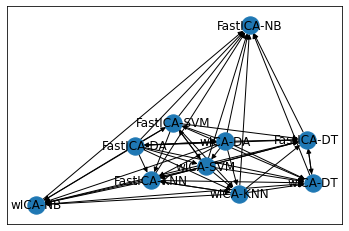

In [139]:
from matplotlib import pyplot as plt

plt.tight_layout()
nx.draw_networkx(graph, arrows=True)
# plt.savefig("g1.png", format="PNG")
plt.show()

### For all pipelines

In [140]:
graph = nx.DiGraph()

for idx, group in results_df.groupby(["Reference", "Setup ID", "Data ID", "Metric"]):
    for idx_i, row_i in group.iterrows():
        for idx_j, row_j in group.iterrows():
            if idx_i > idx_j:
                if row_i["rank"] <= row_j["rank"]:
                    graph.add_edge(row_i["Pipeline"], row_j["Pipeline"])
                if row_j["rank"] <= row_i["rank"]:
                    graph.add_edge(row_j["Pipeline"], row_i["Pipeline"])

print(f"The dominance graph has {len(graph.edges())} edges.")

The dominance graph has 1359 edges.


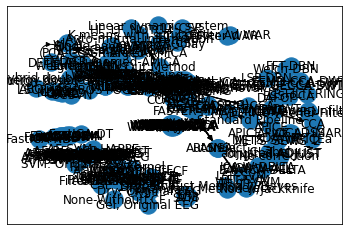

In [141]:
plt.tight_layout()
nx.draw_networkx(graph, arrows=True)
# plt.savefig("g1.png", format="PNG")
plt.show()

In [142]:
# pipe_dom_df = pd.DataFrame(index=list(graph.nodes), columns=["sup", "inf"])
# pipe_dom_df[:] = 0

# for sup, inf in graph.edges():
#     pipe_dom_df.loc[sup, "sup"] += 1
#     pipe_dom_df.loc[inf, "inf"] += 1
    
# pipe_dom_df["sum"] = pipe_dom_df["sup"] + pipe_dom_df["inf"]
# pipe_dom_df["diff"] = pipe_dom_df["sup"] - pipe_dom_df["inf"]
# pipe_dom_df["ratio"] = pipe_dom_df["sup"] / (pipe_dom_df["sup"] + pipe_dom_df["inf"])

# pipe_dom_df.sort_values("ratio", ascending=False)
# pipe_dom_df = pipe_dom_df.merge(pipeline_means, how="inner", left_index=True, right_on="Pipeline")
# pipe_dom_df